<a href="https://colab.research.google.com/github/mdaashir/Smart-Support/blob/main/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn pandas numpy matplotlib seaborn

In [2]:
import random
import pandas as pd
import numpy as np
import re
import heapq
import uuid
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
billing_issues = [
    "charged twice", "refund request", "invoice incorrect",
    "payment failed", "subscription renewal issue",
    "billing address update", "credit card declined",
    "unexpected charge", "pricing discrepancy"
]

technical_issues = [
    "app not loading", "server down", "login failed",
    "500 internal error", "feature not working",
    "API timeout", "database crash",
    "slow performance", "bug in dashboard"
]

legal_issues = [
    "contract agreement", "terms and conditions",
    "data privacy compliance", "legal notice",
    "service agreement clarification",
    "GDPR request", "data deletion request",
    "liability concern"
]

urgency_words = [
    "ASAP", "urgent", "immediately", "critical",
    "right now", "as soon as possible"
]

noise_words = [
    "since yesterday", "after update", "in production",
    "for multiple users", "this morning", "in staging"
]

typos = {
    "payment": "paymnt",
    "server": "servr",
    "agreement": "agreemnt",
    "subscription": "subscrption"
}

def introduce_typo(text):
    for correct, wrong in typos.items():
        if random.random() < 0.1:
            text = text.replace(correct, wrong)
    return text

def generate_ticket(issue_list, label):
    issue = random.choice(issue_list)
    noise = random.choice(noise_words)

    text = f"We are facing {issue} {noise}"

    # 25% mixed category noise
    if random.random() < 0.25:
        mixed = random.choice(billing_issues + technical_issues + legal_issues)
        text += f" and also {mixed}"

    # 30% urgency injection
    if random.random() < 0.3:
        text += f". This is {random.choice(urgency_words)}"

    text = introduce_typo(text)
    return text, label

data = []

for _ in range(6000):
    data.append(generate_ticket(billing_issues, "Billing"))
    data.append(generate_ticket(technical_issues, "Technical"))
    data.append(generate_ticket(legal_issues, "Legal"))

df = pd.DataFrame(data, columns=["text", "category"])
print("Dataset size:", df.shape)
df.head()

Dataset size: (18000, 2)


,text,category
0,We are facing invoice incorrect for multiple u...,Billing
1,We are facing app not loading since yesterday,Technical
2,We are facing contract agreement in production,Legal
3,We are facing subscription renewal issue after...,Billing
4,We are facing servr down in staging,Technical


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["category"],
    test_size=0.2,
    random_state=42,
    stratify=df["category"]
)

model = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        max_features=15000,
        stop_words="english"
    )),
    ("clf", LogisticRegression(max_iter=500))
])

model.fit(X_train, y_train)

preds = model.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

     Billing       1.00      1.00      1.00      1200
       Legal       1.00      1.00      1.00      1200
   Technical       1.00      1.00      1.00      1200

    accuracy                           1.00      3600
   macro avg       1.00      1.00      1.00      3600
weighted avg       1.00      1.00      1.00      3600



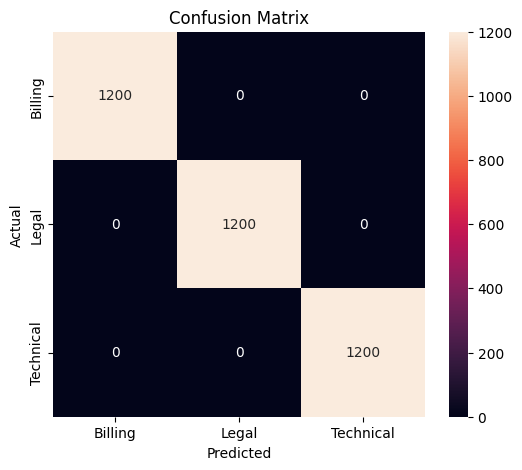

In [5]:
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [6]:
urgent_keywords = [
    "urgent", "asap", "immediately",
    "critical", "right now",
    "broken", "not working",
    "failed", "down", "error"
]

def detect_urgency(text):
    text = text.lower()
    for word in urgent_keywords:
        if re.search(rf"\b{word}\b", text):
            return 1  # High priority
    return 5  # Normal priority

In [7]:
# Initialize queue and counter
ticket_queue = []
counter = 0  # tie-breaker to avoid dict comparison in heap


def ingest_ticket(text):
    global counter

    category = model.predict([text])[0]
    priority = detect_urgency(text)

    ticket = {
        "ticket_id": str(uuid.uuid4()),
        "text": text,
        "category": category,
        "priority": priority
    }

    # Push (priority, counter, ticket)
    heapq.heappush(ticket_queue, (priority, counter, ticket))
    counter += 1

    return ticket


def process_next_ticket():
    if ticket_queue:
        return heapq.heappop(ticket_queue)[2]  # index 2 = ticket
    return None

In [8]:
# Simulate 20 random incoming tickets
for _ in range(20):
    sample_text = df.sample(1)["text"].values[0]
    ticket = ingest_ticket(sample_text)
    print("Ingested:", ticket["category"], "| Priority:", ticket["priority"])

print("\nProcessing Tickets in Priority Order:\n")

while ticket_queue:
    ticket = process_next_ticket()
    print("Processed:",
          "| Category:", ticket["category"],
          "| Priority:", ticket["priority"])

Ingested: Legal | Priority: 5
Ingested: Technical | Priority: 5
Ingested: Legal | Priority: 1
Ingested: Legal | Priority: 5
Ingested: Legal | Priority: 1
Ingested: Technical | Priority: 5
Ingested: Legal | Priority: 5
Ingested: Billing | Priority: 1
Ingested: Legal | Priority: 5
Ingested: Technical | Priority: 5
Ingested: Billing | Priority: 1
Ingested: Billing | Priority: 1
Ingested: Billing | Priority: 5
Ingested: Billing | Priority: 5
Ingested: Billing | Priority: 1
Ingested: Billing | Priority: 1
Ingested: Billing | Priority: 5
Ingested: Billing | Priority: 5
Ingested: Legal | Priority: 5
Ingested: Legal | Priority: 5

Processing Tickets in Priority Order:

Processed: | Category: Legal | Priority: 1
Processed: | Category: Legal | Priority: 1
Processed: | Category: Billing | Priority: 1
Processed: | Category: Billing | Priority: 1
Processed: | Category: Billing | Priority: 1
Processed: | Category: Billing | Priority: 1
Processed: | Category: Billing | Priority: 1
Processed: | Catego

In [12]:
#updated code with dataset
import re
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

# ------------------------------------
# LOAD DATASET
# ------------------------------------
DATA_PATH = "/content/drive/MyDrive/ss/aa_dataset-tickets-multi-lang-5-2-50-version.csv"
df = pd.read_csv(DATA_PATH)

# ------------------------------------
# TEXT PREPROCESSING
# ------------------------------------
df["text"] = (
    df["subject"].fillna("") + " " +
    df["body"].fillna("")
).str.lower()

# ------------------------------------
# LABEL MAPPING (DATA-DRIVEN)
# ------------------------------------
def map_queue_to_category(queue):
    q = str(queue).lower()

    if "billing" in q or "payment" in q:
        return "Billing"
    elif "legal" in q or "compliance" in q:
        return "Legal"
    else:
        return "Technical"

df["label"] = df["queue"].apply(map_queue_to_category)

# ------------------------------------
# TRAIN / TEST SPLIT
# ------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    df["text"],
    df["label"],
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# ------------------------------------
# MULTI-LINGUAL TF-IDF (CHAR N-GRAMS)
# ------------------------------------
vectorizer = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=5,
    max_features=20000
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# ------------------------------------
# CLASSIFIER
# ------------------------------------
model = LinearSVC(class_weight="balanced")
model.fit(X_train_vec, y_train)

# ------------------------------------
# EVALUATION
# ------------------------------------
y_pred = model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("Weighted F1:", f1_score(y_test, y_pred, average="weighted"))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# ------------------------------------
# URGENCY HEURISTIC (MILESTONE-1)
# ------------------------------------
URGENT_REGEX = re.compile(
    r"\b(asap|urgent|immediately|critical|down|outage|breach)\b",
    re.IGNORECASE
)

def detect_urgency(text: str):
    return "1(HIGH)" if URGENT_REGEX.search(text) else "0(NORMAL)"

# ------------------------------------
# FINAL ROUTING FUNCTION
# ------------------------------------
def route_ticket(subject: str, body: str):
    text = (subject + " " + body).lower()
    vec = vectorizer.transform([text])

    return {
        "category": model.predict(vec)[0],
        "urgency": detect_urgency(text)
    }

# ------------------------------------
# SAMPLE TEST
# ------------------------------------
if __name__ == "__main__":
    sample = route_ticket(
        "Invoice issue",
        "Charged twice for last month subscription"
    )
    print("\nSample Output:")
    print(sample)

Accuracy: 0.9375655823714586
Macro F1: 0.8419991462659974
Weighted F1: 0.9408965465262474

Classification Report:

              precision    recall  f1-score   support

     Billing       0.64      0.82      0.72       558
   Technical       0.98      0.95      0.96      5160

    accuracy                           0.94      5718
   macro avg       0.81      0.88      0.84      5718
weighted avg       0.95      0.94      0.94      5718


Sample Output:
{'category': 'Billing', 'urgency': '0(NORMAL)'}


In [13]:
!pip install -q transformers datasets accelerate evaluate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.2 MB/s eta 0:00:00


In [14]:
import torch
print(torch.cuda.get_device_name(0))

Tesla T4


In [15]:
import torch
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, accuracy_score

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

In [16]:
DATA_PATH ="/content/drive/MyDrive/ss/aa_dataset-tickets-multi-lang-5-2-50-version.csv"
df = pd.read_csv(DATA_PATH)

df["text"] = (
    df["subject"].fillna("") + " " +
    df["body"].fillna("")
).str.lower()

In [17]:
def map_queue_to_category(queue):
    q = str(queue).lower()

    if "billing" in q or "payment" in q:
        return "Billing"
    elif "legal" in q or "compliance" in q:
        return "Legal"
    else:
        return "Technical"

df["label"] = df["queue"].apply(map_queue_to_category)

In [18]:
label_encoder = LabelEncoder()
df["label_id"] = label_encoder.fit_transform(df["label"])

num_labels = len(label_encoder.classes_)

In [19]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"],
    df["label_id"],
    test_size=0.2,
    stratify=df["label_id"],
    random_state=42
)

In [20]:
MODEL_NAME = "xlm-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

XLMRobertaForSequenceClassification LOAD REPORT from: xlm-roberta-base
Key                         | Status     | 
----------------------------+------------+-
lm_head.layer_norm.weight   | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
roberta.pooler.dense.bias   | UNEXPECTED | 
classifier.dense.weight     | MISSING    | 
classifier.out_proj.bias    | MISSING    | 
classifier.out_proj.weight  | MISSING    | 
classifier.dense.bias       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [21]:
train_encodings = tokenizer(
    list(train_texts),
    truncation=True,
    padding=True,
    max_length=256
)

test_encodings = tokenizer(
    list(test_texts),
    truncation=True,
    padding=True,
    max_length=256
)

In [22]:
class TicketDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TicketDataset(train_encodings, train_labels)
test_dataset = TicketDataset(test_encodings, test_labels)

In [33]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
)

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


In [34]:
import evaluate
metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_score(labels, predictions),
        "macro_f1": f1_score(labels, predictions, average="macro"),
    }

In [35]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [36]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.146279,0.156890,0.957328,0.855790
2,0.129894,0.152999,0.956978,0.865941
3,0.109612,0.178151,0.959776,0.873980


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

TrainOutput(global_step=4290, training_loss=0.12750980715095858, metrics={'train_runtime': 3574.9596, 'train_samples_per_second': 19.191, 'train_steps_per_second': 1.2, 'total_flos': 9025630087541760.0, 'train_loss': 0.12750980715095858, 'epoch': 3.0})

In [37]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.17815086245536804, 'eval_accuracy': 0.9597761455054215, 'eval_macro_f1': 0.8739804522805672, 'eval_runtime': 74.6905, 'eval_samples_per_second': 76.556, 'eval_steps_per_second': 4.793, 'epoch': 3.0}


In [38]:
from transformers import AutoModelForSequenceClassification

SENT_MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

sent_tokenizer = AutoTokenizer.from_pretrained(SENT_MODEL)
sent_model = AutoModelForSequenceClassification.from_pretrained(SENT_MODEL)

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

XLMRobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-xlm-roberta-base-sentiment
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [44]:
import torch.nn.functional as F

def get_urgency_score(text):
    inputs = sent_tokenizer(text, return_tensors="pt", truncation=True)
    outputs = sent_model(**inputs)

    probs = F.softmax(outputs.logits, dim=1)

    # index 0 = Negative
    negative_score = probs[0][0].item()

    return float(negative_score)

In [45]:
def route_ticket_transformer(subject: str, body: str):
    text = (subject + " " + body).lower()

    # Category Prediction
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()} # Move inputs to model's device
    outputs = model(**inputs)

    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    category = label_encoder.inverse_transform([predicted_class])[0]

    # Continuous Urgency Score
    inputs_sent = sent_tokenizer(text, return_tensors="pt", truncation=True)
    inputs_sent = {k: v.to(sent_model.device) for k, v in inputs_sent.items()} # Move inputs to sentiment model's device
    outputs_sent = sent_model(**inputs_sent)

    probs = F.softmax(outputs_sent.logits, dim=1)

    # Index 2 = Negative sentiment
    negative_score = probs[0][2].item()

    return {
        "category": category,
        "urgency_score": round(negative_score, 3)
    }

In [46]:
sample = route_ticket_transformer(
    "System outage",
    "Our production server is completely down. Immediate help required!"
)

print(sample)

{'category': 'Technical', 'urgency_score': 0.02}
